In [3]:
pip uninstall scikit-learn

^C
Found existing installation: scikit-learn 1.5.0
Uninstalling scikit-learn-1.5.0:
  Would remove:
    c:\users\lenovo\anaconda3\lib\site-packages\scikit_learn-1.5.0.dist-info\*
    c:\users\lenovo\anaconda3\lib\site-packages\sklearn\*
Proceed (Y/n)? 
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from PIL import Image, ImageOps, ImageEnhance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
# Image folders
healthy_path = "C:/Users/Lenovo/Coral/healthy_corals"
bleached_path = "C:/Users/Lenovo/Coral/bleached_corals"
categories = ['healthy_corals', 'bleached_corals']

In [5]:
# Image dimensions
IMG_SIZE = (64, 64)  # Reducing size to 64x64 to further reduce computational load

unique_images = []
unique_labels = []
image_paths = {}
duplicates = []

In [7]:
# Loading and processing images
for category in categories:
    path = os.path.join("C:/Users/Lenovo/Coral", category)
    class_num = categories.index(category)

    for img_name in tqdm(os.listdir(path), desc=f"Loading {category} images"):
        img_path = os.path.join(path, img_name)
        img = Image.open(img_path).resize(IMG_SIZE)   # Open and resize image
        img_array = np.array(img)

        is_duplicate = False
        for unique_img in unique_images:
            if np.array_equal(img_array, unique_img):
                duplicates.append((img_path, image_paths[tuple(unique_img.flatten())]))
                is_duplicate = True
                break

        if not is_duplicate:
            unique_images.append(img_array)
            unique_labels.append(class_num)
            image_paths[tuple(img_array.flatten())] = img_path

images = np.array(unique_images)
labels = np.array(unique_labels)

print(f"Loaded {len(images)} unique images")
print(f"Found {len(duplicates)} duplicate images")

Loading bleached_corals images: 100%|███████████████████████████████████████████████| 473/473 [00:04<00:00, 118.04it/s]


Loaded 905 unique images
Found 0 duplicate images


In [9]:
# Printing duplicate images
for dup in duplicates:
    img1_path, img2_path = dup
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img1)
    axes[0].set_title(f'Duplicate Image: {img1_path}')
    axes[1].imshow(img2)
    axes[1].set_title(f'Original Image: {img2_path}')
    plt.show()

In [11]:
# Removing duplicates
for duplicate, original in duplicates:
    try:
        os.remove(duplicate)
        print(f"Removed duplicate: {duplicate}")
    except OSError as e:
        print(f"Error: {e.strerror} - {duplicate}")

In [13]:
# Checking remaining images
remaining_images = []
for category in categories:
    path = os.path.join('C:/Users/Lenovo/Coral', category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        remaining_images.append(img_path)

print(f"Remaining images after duplicate removal: {len(remaining_images)}")

Remaining images after duplicate removal: 905


In [15]:
# Augmenting images with progress bar
augmented_images = []
augmented_labels = []

for img, label in tqdm(zip(images, labels), desc="Augmenting images", total=len(images)):
    augmented_images.append(img)
    augmented_images.append(np.array(ImageOps.mirror(Image.fromarray(img))))
    augmented_images.append(np.array(Image.fromarray(img).rotate(90)))
    augmented_labels.extend([label, label, label])

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print(f"Augmented data size: {len(augmented_images)} images")

Augmenting images: 100%|███████████████████████████████████████████████████████████| 905/905 [00:00<00:00, 7342.49it/s]

Augmented data size: 2715 images


In [17]:
# Converting images to grayscale with progress bar
grayscale_images = np.array([np.array(Image.fromarray(img).convert('L')) for img in tqdm(augmented_images, desc="Converting to grayscale")])

print("Converted images to grayscale")


Converting to grayscale: 100%|██████████████████████████████████████████████████| 2715/2715 [00:00<00:00, 18928.06it/s]

Converted images to grayscale


In [19]:
# Adjusting contrast and brightness with progress bar
adjusted_images = []
for img in tqdm(grayscale_images, desc="Adjusting contrast and brightness"):
    img_pil = Image.fromarray(img)
    contrast_enhancer = ImageEnhance.Contrast(img_pil)
    img_contrast = contrast_enhancer.enhance(2)
    brightness_enhancer = ImageEnhance.Brightness(img_contrast)
    img_bright = brightness_enhancer.enhance(1.5)
    adjusted_images.append(np.array(img_bright))

adjusted_images = np.array(adjusted_images)

print("Adjusted contrast and brightness of images")

Adjusting contrast and brightness: 100%|█████████████████████████████████████████| 2715/2715 [00:00<00:00, 5395.40it/s]

Adjusted contrast and brightness of images


In [21]:
# Flatten grayscale images
flattened_images = []
for img in tqdm(adjusted_images, desc="Flattening images"):
    flattened_img = np.array(img).flatten()
    flattened_images.append(flattened_img)

flattened_images = np.array(flattened_images)

# Dataset dictionary
dataset = {'Label': augmented_labels}
for i in range(flattened_images.shape[1]):
    dataset[f'Pixel_{i}'] = flattened_images[:, i]

# Create DataFrame
df = pd.DataFrame(dataset)

print(df.head())

Flattening images: 100%|███████████████████████████████████████████████████████| 2715/2715 [00:00<00:00, 128848.88it/s]


   Label  Pixel_0  Pixel_1  Pixel_2  Pixel_3  Pixel_4  Pixel_5  Pixel_6  \
0      0       85       85       82       85       91       88       94   
1      0       82      109       88       91      145      187      169   
2      0       82       61       46       43       28       19       67   
3      0      255      255      255      255      255      255      255   
4      0      255      255      255      255      255      255      255   

   Pixel_7  Pixel_8  ...  Pixel_4086  Pixel_4087  Pixel_4088  Pixel_4089  \
0      115      112  ...         255         255         255         172   
1      169      118  ...           0          94          85         106   
2      166      127  ...          52          52         118          64   
3      255      255  ...           0           0           0           0   
4      255      255  ...           0           0           0          15   

   Pixel_4090  Pixel_4091  Pixel_4092  Pixel_4093  Pixel_4094  Pixel_4095  
0          82   

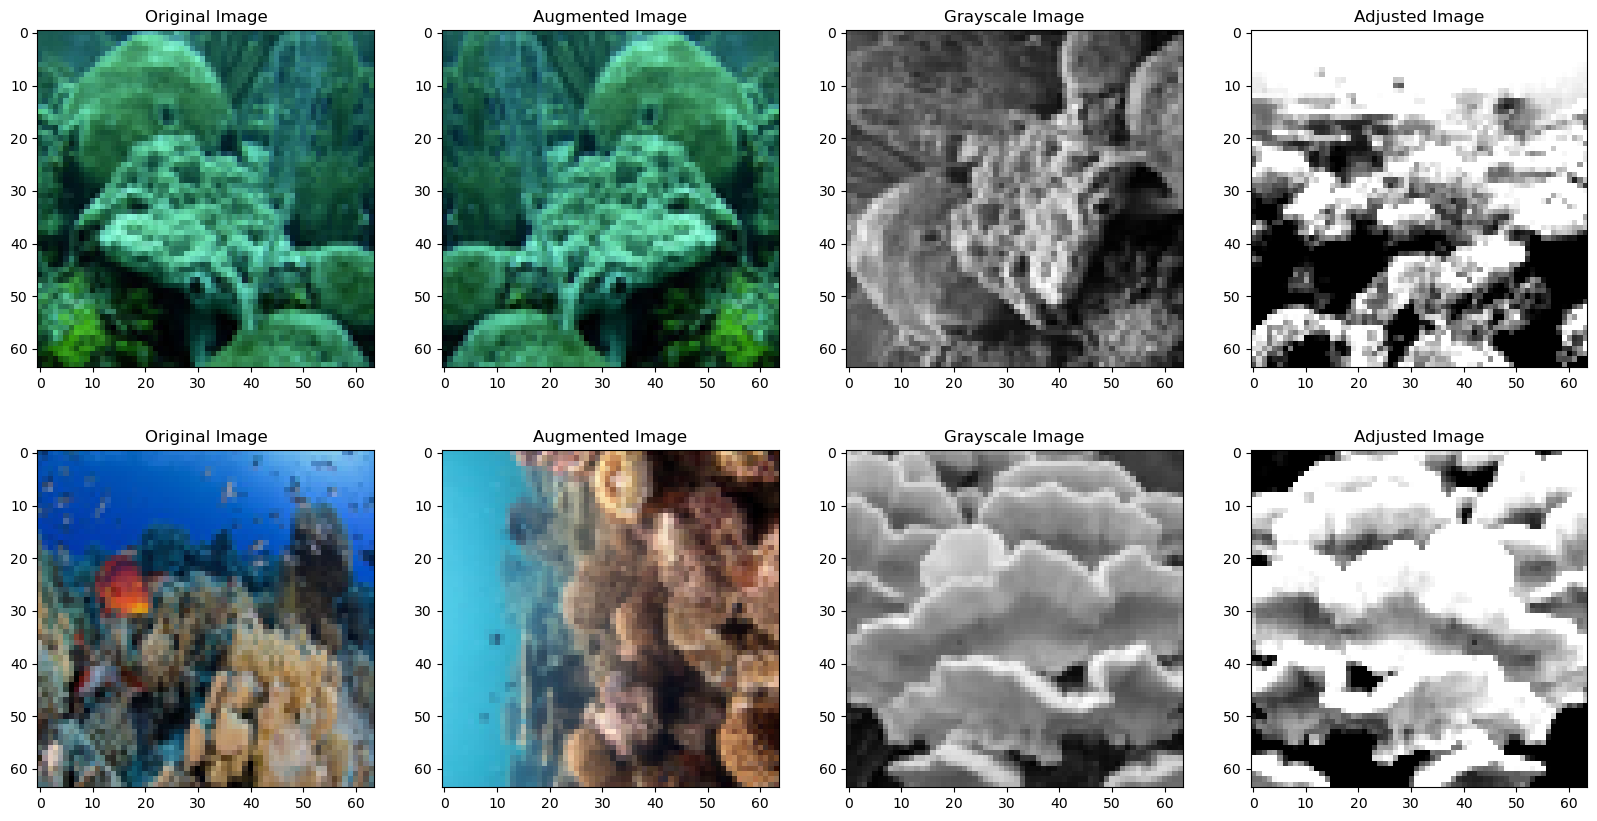

In [23]:
# Plotting original, augmented, grayscale, and adjusted images
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs[0, 0].imshow(images[0])
axs[0, 0].set_title("Original Image")

axs[0, 1].imshow(augmented_images[1])
axs[0, 1].set_title("Augmented Image")

axs[0, 2].imshow(grayscale_images[2], cmap='gray')
axs[0, 2].set_title("Grayscale Image")

axs[0, 3].imshow(adjusted_images[3], cmap='gray')
axs[0, 3].set_title("Adjusted Image")

axs[1, 0].imshow(images[4])
axs[1, 0].set_title("Original Image")

axs[1, 1].imshow(augmented_images[5])
axs[1, 1].set_title("Augmented Image")

axs[1, 2].imshow(grayscale_images[6], cmap='gray')
axs[1, 2].set_title("Grayscale Image")

axs[1, 3].imshow(adjusted_images[7], cmap='gray')
axs[1, 3].set_title("Adjusted Image")

plt.show()

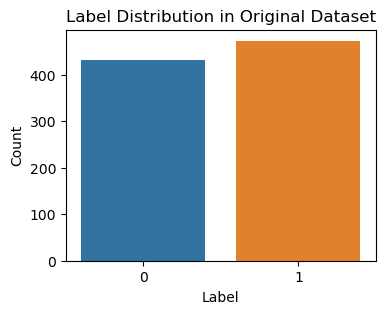

In [25]:
# Label distribution
plt.figure(figsize=(4, 3))
sns.countplot(x=labels)
plt.title('Label Distribution in Original Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

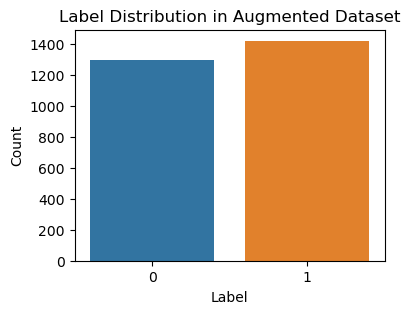

In [27]:
# Label distribution after augmentation
plt.figure(figsize=(4, 3))
sns.countplot(x=augmented_labels)
plt.title('Label Distribution in Augmented Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

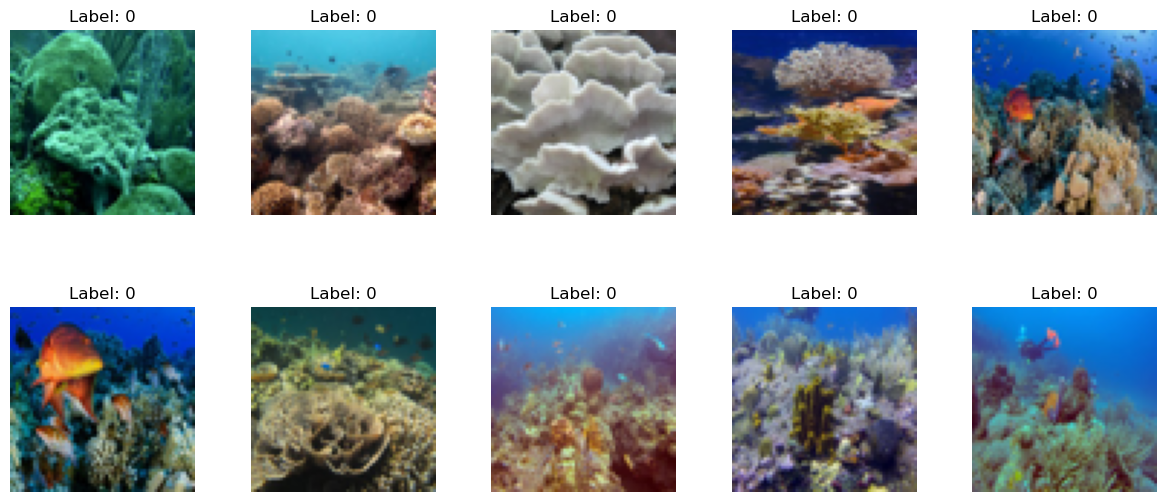

In [29]:
# Original images with labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
for i in np.arange(0, 10):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Label: {labels[i]}')
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()

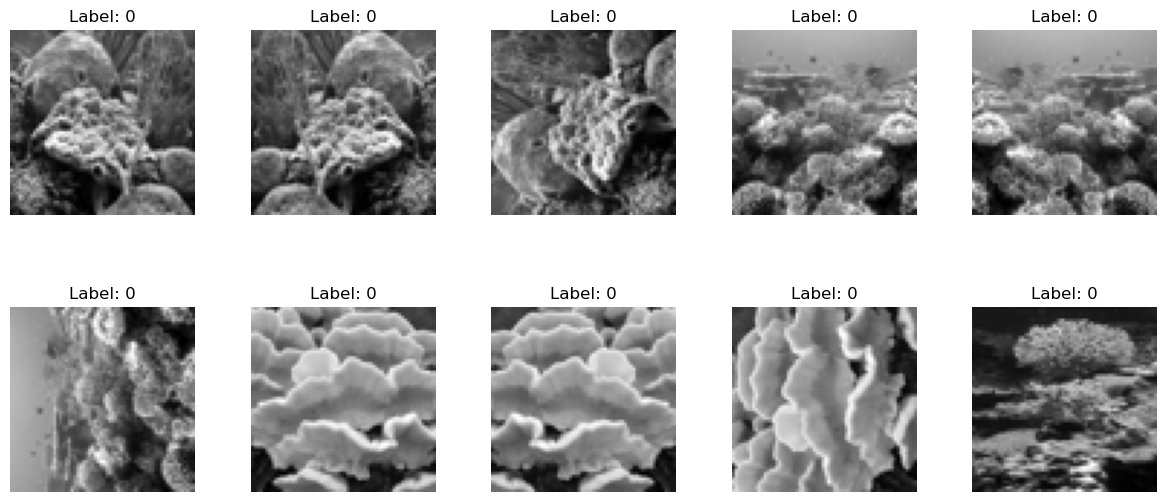

In [31]:
# Grayscale images with labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
for i in np.arange(0, 10):
    axes[i].imshow(grayscale_images[i], cmap='gray')
    axes[i].set_title(f'Label: {augmented_labels[i]}')
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()

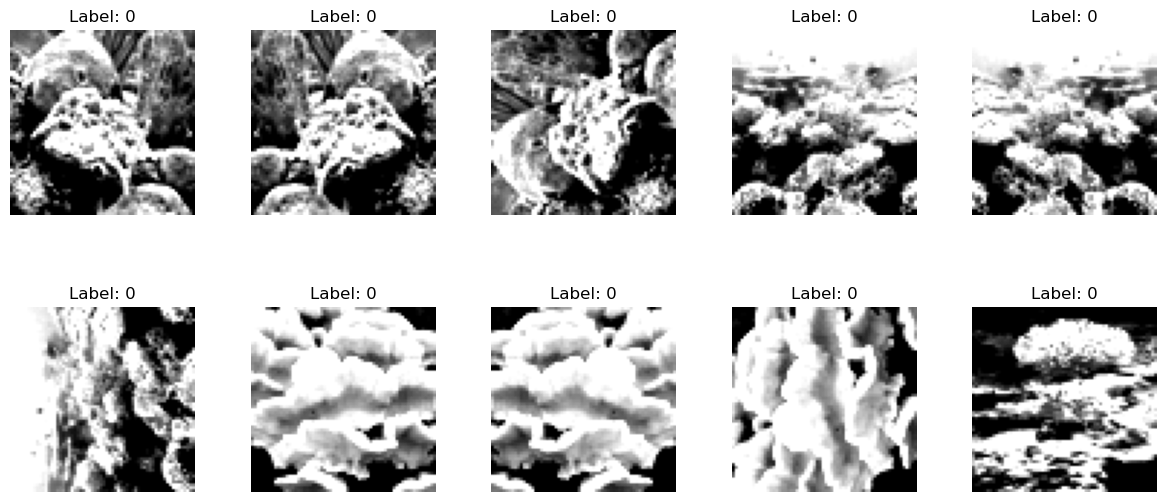

In [33]:
# Adjusted images with labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
for i in np.arange(0, 10):
    axes[i].imshow(adjusted_images[i], cmap='gray')
    axes[i].set_title(f'Label: {augmented_labels[i]}')
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# Key Steps:
# Resizing Images: Images are resized to 64*64 to reduce the dataset size.
# Image Augmentation: Images are mirrored and rotated to increase the dataset size.
# Grayscale Conversion: Images are converted to grayscale.
# Contrast and Brightness Adjustment: The contrast and brightness of the images are enhanced.
# Flattening: Grayscale images are flattened into 1D arrays.
# Creating and Saving CSV: A DataFrame is created from the flattened images and labels.

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

df.head()

,Label,Pixel_0,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,...,Pixel_4086,Pixel_4087,Pixel_4088,Pixel_4089,Pixel_4090,Pixel_4091,Pixel_4092,Pixel_4093,Pixel_4094,Pixel_4095
0,0,85,85,82,85,91,88,94,115,112,...,255,255,255,172,82,166,181,157,118,0
1,0,82,109,88,91,145,187,169,169,118,...,0,94,85,106,40,0,0,0,0,0
2,0,82,61,46,43,28,19,67,166,127,...,52,52,118,64,10,0,0,0,0,0
3,0,255,255,255,255,255,255,255,255,255,...,0,0,0,0,0,132,0,0,0,0
4,0,255,255,255,255,255,255,255,255,255,...,0,0,0,15,81,6,0,129,201,78


In [27]:
# Splitting the data into features and labels
X = df.drop(columns=['Label'])
y = df['Label']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
pip install --upgrade scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# SVM pipeline and hyperparameter tuning
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

svm_param_grid = {
    'svc__C': [0.01, 0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto']  # Adding gamma for the RBF kernel
}

# Cross-validation and GridSearch
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, n_jobs=-1, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)

print(f"Best SVM Parameters: {svm_grid_search.best_params_}")
print(f"Best SVM Train Accuracy: {svm_grid_search.best_score_:.4f}")

# Evaluate on test set
svm_test_accuracy = svm_grid_search.score(X_test, y_test)
print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")


Best SVM Parameters: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best SVM Train Accuracy: 0.6363
SVM Test Accuracy: 0.6427


In [31]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest pipeline and hyperparameter tuning
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier())
])

rf_param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# Cross-validation and GridSearch
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, n_jobs=-1, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

print(f"Best RF Parameters: {rf_grid_search.best_params_}")
print(f"Best RF Train Accuracy: {rf_grid_search.best_score_:.4f}")

# Evaluate on test set
rf_test_accuracy = rf_grid_search.score(X_test, y_test)
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")


Best RF Parameters: {'rf__max_depth': 20, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}
Best RF Train Accuracy: 0.6542
Random Forest Test Accuracy: 0.6519


In [33]:
from sklearn.neighbors import KNeighborsClassifier

# KNN pipeline and hyperparameter tuning
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Cross-validation and GridSearch
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, n_jobs=-1, scoring='accuracy')
knn_grid_search.fit(X_train, y_train)

print(f"Best KNN Parameters: {knn_grid_search.best_params_}")
print(f"Best KNN Train Accuracy: {knn_grid_search.best_score_:.4f}")

# Evaluate on test set
knn_test_accuracy = knn_grid_search.score(X_test, y_test)
print(f"KNN Test Accuracy: {knn_test_accuracy:.4f}")


Best KNN Parameters: {'knn__algorithm': 'auto', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
Best KNN Train Accuracy: 0.6220
KNN Test Accuracy: 0.5838


In [35]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression pipeline and hyperparameter tuning
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

logreg_param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__solver': ['liblinear', 'lbfgs']
}

# Cross-validation and GridSearch
logreg_grid_search = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, n_jobs=-1, scoring='accuracy')
logreg_grid_search.fit(X_train, y_train)

print(f"Best LogReg Parameters: {logreg_grid_search.best_params_}")
print(f"Best LogReg Train Accuracy: {logreg_grid_search.best_score_:.4f}")

# Evaluate on test set
logreg_test_accuracy = logreg_grid_search.score(X_test, y_test)
print(f"Logistic Regression Test Accuracy: {logreg_test_accuracy:.4f}")


Best LogReg Parameters: {'logreg__C': 0.01, 'logreg__solver': 'liblinear'}
Best LogReg Train Accuracy: 0.5506
Logistic Regression Test Accuracy: 0.5285
